# Moving averages


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint

from utils import get_data, get_return_simulation


In [2]:
PATH = "../data/moving_averages.csv"
stocks = ["MFED.PA", "PE500.PA", "EN.PA", "CNP.PA", "TTE.PA", "^GSPC"]
weights = [0.5, 0.4, 0.023, 0.033, 0.043]


## Get stocks data


array([[<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>]],
      dtype=object)

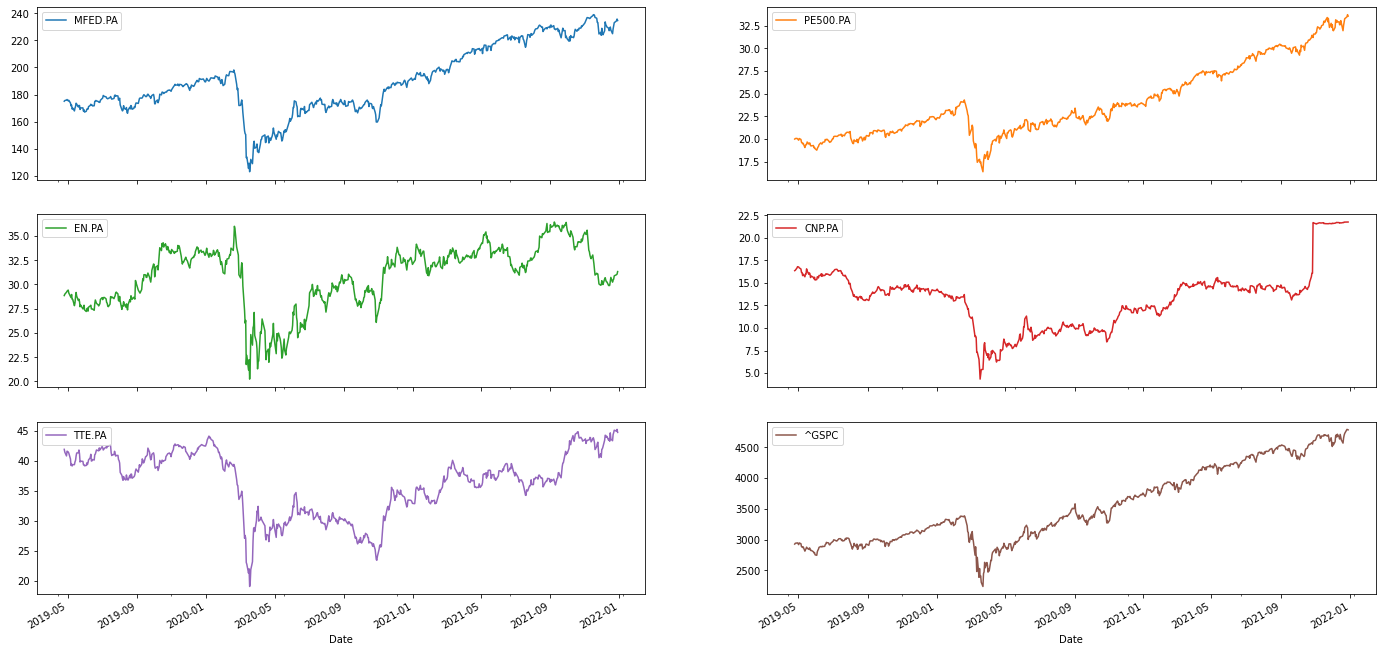

In [3]:
df = get_data(path=PATH, stocks=stocks)

df.plot(figsize=(24, 12), subplots=True, layout=(3, 2))


## Example of a strategy base on 2 simple moving averages


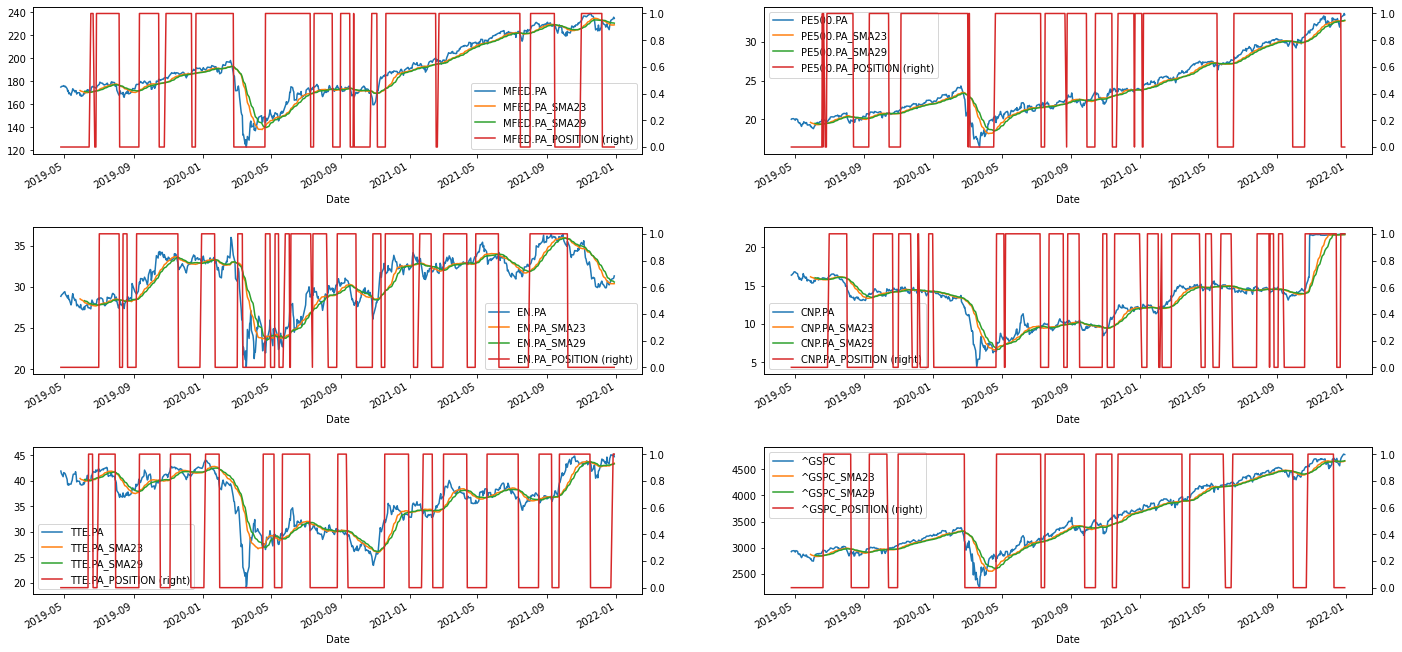

In [4]:
SMA1 = 23
SMA2 = 29

fig, axes = plt.subplots(nrows=3, ncols=2)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

for i, s in enumerate(stocks):
    df[f"{s}_SMA{SMA1}"] = df[s].rolling(SMA1).mean()
    df[f"{s}_SMA{SMA2}"] = df[s].rolling(SMA2).mean()
    df[f"{s}_POSITION"] = np.where(df[f"{s}_SMA{SMA1}"] > df[f"{s}_SMA{SMA2}"], 1, 0)

    df[[s, f"{s}_SMA{SMA1}", f"{s}_SMA{SMA2}", f"{s}_POSITION"]].plot(
        figsize=(24, 12), ax=axes[i // 2, i % 2], secondary_y=f"{s}_POSITION"
    )


## Compute strategy returns and compare to stock returns


{'CNP.PA': {'amount invested': 291.56468772888184,
            'base returns': 1.3298480382757274,
            'strategy returns': 1.641899808801775},
 'EN.PA': {'amount invested': 527.5722141265869,
           'base returns': 1.0857877957232231,
           'strategy returns': 1.0685930369554422},
 'MFED.PA': {'amount invested': 2742.4300079345703,
             'base returns': 1.3412752500825842,
             'strategy returns': 1.2839890133247156},
 'PE500.PA': {'amount invested': 361.82600021362305,
              'base returns': 1.6770999908447266,
              'strategy returns': 1.4832322628928278},
 'TTE.PA': {'amount invested': 601.5471343994141,
            'base returns': 1.0673712024741513,
            'strategy returns': 1.1903971877528416},
 '^GSPC': {'amount invested': 37758.72998046875,
           'base returns': 1.6347239251928483,
           'strategy returns': 1.393539449350491}}


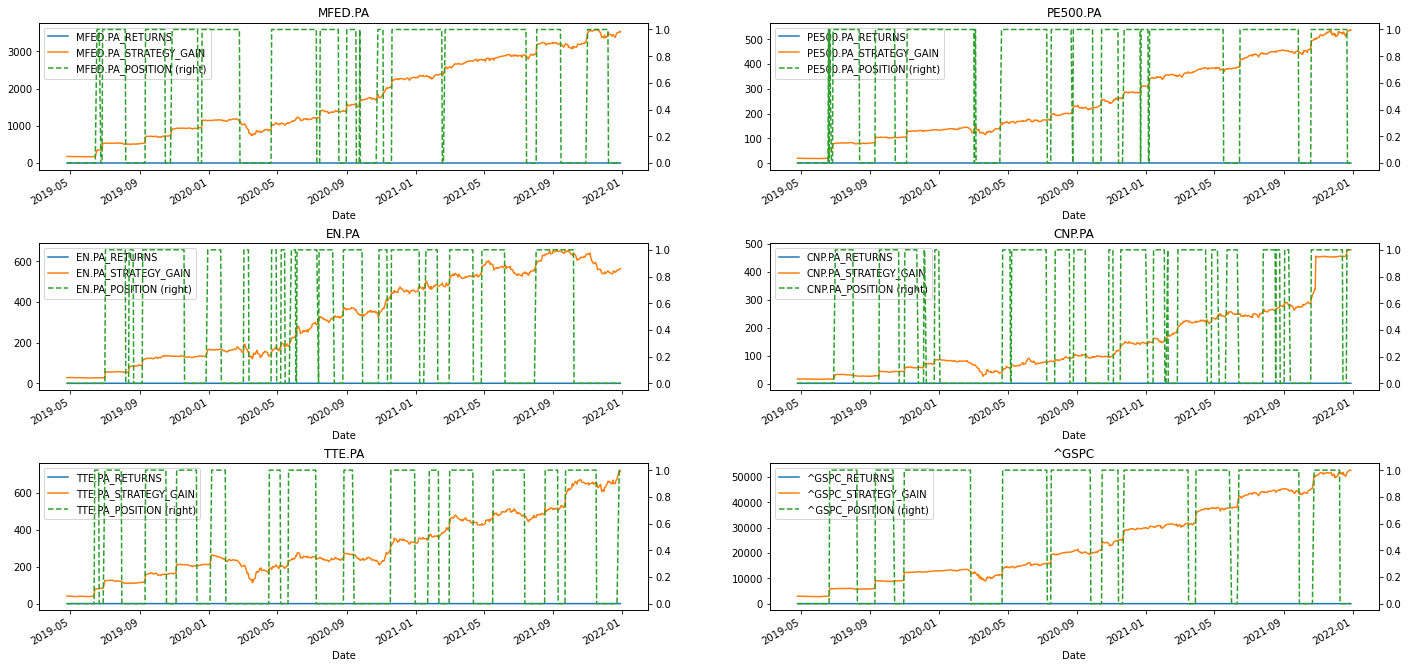

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=2)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

for s in stocks:
    df[f"{s}_TRANSACTIONS"] = df[f"{s}_POSITION"].diff().clip(lower=0)
    df.loc[df.index[0], f"{s}_TRANSACTIONS"] = 1

pprint.pprint(get_return_simulation(df, stocks))

for i, s in enumerate(stocks):
    ax = df[[f"{s}_RETURNS", f"{s}_STRATEGY_GAIN"]].plot(
        figsize=(24, 12), ax=axes[i // 2, i % 2]
    )
    df[[f"{s}_POSITION"]].plot(
        figsize=(24, 12), ax=ax, secondary_y=f"{s}_POSITION", style="--"
    )
    plt.title(s)


## Compute best simple moving average pair


In [6]:
symbols = stocks[:-1]
results = pd.DataFrame()

data = pd.DataFrame(df[symbols])
data.dropna(inplace=True)

for SMA1 in range(2, 31):
    for SMA2 in range(SMA1 + 1, 51):
        for s in symbols:
            data[f"{s}_SMA1"] = data[s].rolling(SMA1).mean()
            data[f"{s}_SMA2"] = data[s].rolling(SMA2).mean()

            data[f"{s}_POSITION"] = np.where(
                data[f"{s}_SMA1"] > data[f"{s}_SMA2"], 1, 0
            )
            data[f"{s}_TRANSACTIONS"] = data[f"{s}_POSITION"].diff().clip(lower=0)
            data.loc[data.index[0], f"{s}_TRANSACTIONS"] = 1

        return_simulation = get_return_simulation(data, symbols)
        market = sum(
            [w * return_simulation[s]["base returns"] for s, w in zip(symbols, weights)]
        )
        strategy = sum(
            [
                w * return_simulation[s]["strategy returns"]
                for s, w in zip(symbols, weights)
            ]
        )

        results = results.append(
            pd.DataFrame(
                {
                    "SMA1": SMA1,
                    "SMA2": SMA2,
                    "market": market,
                    "strategy": strategy,
                    "out": strategy - market,
                },
                index=[0],
            ),
            ignore_index=True,
        )

results.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMA1      986 non-null    int64  
 1   SMA2      986 non-null    int64  
 2   market    986 non-null    float64
 3   strategy  986 non-null    float64
 4   out       986 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 38.6 KB


In [7]:
results.sort_values("out", ascending=False).head(7)


,SMA1,SMA2,market,strategy,out
803,23,29,1.456233,1.365235,-0.090998
804,23,30,1.456233,1.363031,-0.093201
462,12,40,1.456233,1.360504,-0.095729
830,24,30,1.456233,1.360294,-0.095939
805,23,31,1.456233,1.359944,-0.096288
258,7,36,1.456233,1.359727,-0.096505
776,22,29,1.456233,1.359505,-0.096728


## Exponential moving averages


In [8]:
symbols = stocks[:-1]
results = pd.DataFrame()

data = pd.DataFrame(df[symbols])
data.dropna(inplace=True)

for EMA1 in range(2, 31):
    for EMA2 in range(EMA1 + 1, 51):
        for s in symbols:
            data[f"{s}_EMA1"] = data[s].ewm(EMA1, adjust=False).mean()
            data[f"{s}_EMA2"] = data[s].ewm(EMA2, adjust=False).mean()

            data[f"{s}_POSITION"] = np.where(
                data[f"{s}_EMA1"] > data[f"{s}_EMA2"], 1, 0
            )
            data[f"{s}_TRANSACTIONS"] = data[f"{s}_POSITION"].diff().clip(lower=0)
            data.loc[data.index[0], f"{s}_TRANSACTIONS"] = 1

        return_simulation = get_return_simulation(data, symbols)
        market = sum(
            [w * return_simulation[s]["base returns"] for s, w in zip(symbols, weights)]
        )
        strategy = sum(
            [
                w * return_simulation[s]["strategy returns"]
                for s, w in zip(symbols, weights)
            ]
        )

        results = results.append(
            pd.DataFrame(
                {
                    "EMA1": EMA1,
                    "EMA2": EMA2,
                    "market": market,
                    "strategy": strategy,
                    "out": strategy - market,
                },
                index=[0],
            ),
            ignore_index=True,
        )

results.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   EMA1      986 non-null    int64  
 1   EMA2      986 non-null    int64  
 2   market    986 non-null    float64
 3   strategy  986 non-null    float64
 4   out       986 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 38.6 KB


In [13]:
results.sort_values("out", ascending=False).head(10)


,EMA1,EMA2,market,strategy,out
140,4,50,1.456233,1.462601,0.006368
139,4,49,1.456233,1.462027,0.005794
181,5,46,1.456233,1.457973,0.001741
268,7,46,1.456233,1.457343,0.001110
182,5,47,1.456233,1.457104,0.000872
266,7,44,1.456233,1.456963,0.000730
306,8,42,1.456233,1.456777,0.000544
305,8,41,1.456233,1.456437,0.000204
271,7,49,1.456233,1.455844,-0.000388
272,7,50,1.456233,1.455813,-0.000419


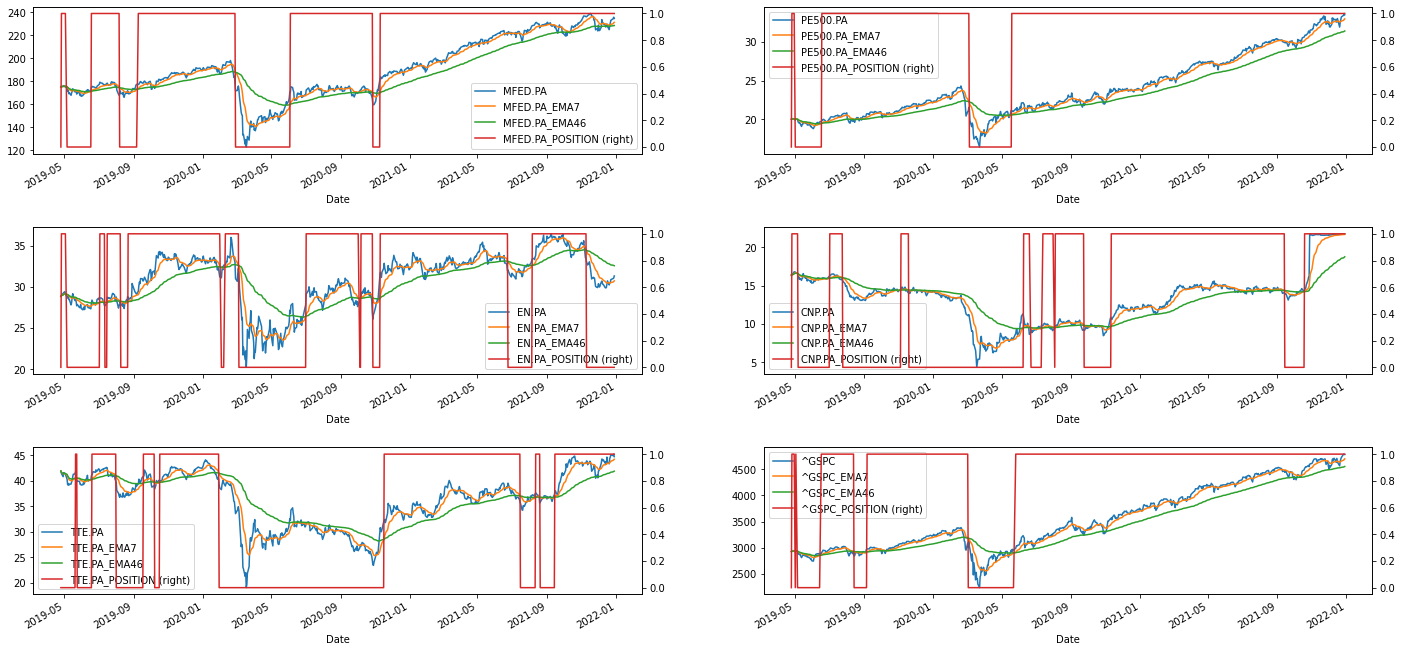

In [15]:
EMA1 = 7
EMA2 = 46

fig, axes = plt.subplots(nrows=3, ncols=2)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

for i, s in enumerate(stocks):
    df[f"{s}_EMA{EMA1}"] = df[s].ewm(EMA1).mean()
    df[f"{s}_EMA{EMA2}"] = df[s].ewm(EMA2).mean()
    df[f"{s}_POSITION"] = np.where(df[f"{s}_EMA{EMA1}"] > df[f"{s}_EMA{EMA2}"], 1, 0)

    df[[s, f"{s}_EMA{EMA1}", f"{s}_EMA{EMA2}", f"{s}_POSITION"]].plot(
        figsize=(24, 12), ax=axes[i // 2, i % 2], secondary_y=f"{s}_POSITION"
    )


## Conclusion

- We did not find a SMA pair that consistently have higher returns than staying in the market
- In the method to find the best pair, all stocks were equally weighted
- SMA cannot be used for buy/sell signals by itself
- EMA produce more profitable signals than SMA

- Try with 3 SMA to generate signal
- Try to optimize with weights
